# Local Retailer Sales Forecasting

## Exploratory Data Analysis

The goal of this project is to forecast daily or weekly sales for a Massachusetts-based local retailer that specializes in equestrian equipment. Before diving into modeling, let's understand the raw sales data and its underlying drivers through EDA.

### Notebook Setup

In [41]:
%matplotlib inline

from __future__ import division
from __future__ import print_function

# ignore deprecation warnings in sklearn
import warnings
warnings.filterwarnings("ignore")

# Import Pandas, Matplotlib, etc
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

### Load Daily Sales Data
Load the sales data into a Pandas dataframe and use the date as a DatetimeIndex.  There's more daily sales data available going back to June of 2016 but it's not as deep or accurate.  This sales info was generated through a Square POS system where the legacy data (prior to Nov 2017) was all from paper receipts.

In [42]:
daily_sales_df = pd.read_excel('../data/daily-sales.xlsx', index_col='date', parse_dates=True)

daily_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 326 entries, 2017-11-17 to 2018-10-08
Data columns (total 7 columns):
year         326 non-null int64
month        326 non-null int64
week         326 non-null int64
day          326 non-null int64
sales        326 non-null float64
customers    326 non-null int64
avg_sale     326 non-null float64
dtypes: float64(2), int64(5)
memory usage: 20.4 KB


### Summary Statistics

Running Pandas "describe" on the numeric columns (sales, customers, avg_sale) shows fairly high variance for each. 

In [43]:
daily_sales_df.head(10)

,year,month,week,day,sales,customers,avg_sale
date,,,,,,,
2017-11-17,2017,11,46,5,348.63,11,31.693636
2017-11-18,2017,11,46,6,1334.38,16,83.398750
2017-11-19,2017,11,46,0,153.93,2,76.965000
2017-11-20,2017,11,47,1,512.08,3,170.693333
2017-11-21,2017,11,47,2,0.00,0,0.000000
2017-11-22,2017,11,47,3,1132.31,8,141.538750
2017-11-23,2017,11,47,4,0.00,0,0.000000
2017-11-24,2017,11,47,5,2529.53,34,74.397941
2017-11-25,2017,11,47,6,1545.76,23,67.206957


In [44]:
daily_sales_df[['sales', 'customers', 'avg_sale']].describe()

,sales,customers,avg_sale
count,326.000000,326.000000,326.000000
mean,726.663681,8.503067,76.349386
std,726.209640,6.320053,50.091222
min,0.000000,0.000000,0.000000
25%,243.770000,4.000000,50.341250
50%,556.540000,8.000000,73.369619
75%,1039.095000,11.750000,94.563333
max,7478.240000,34.000000,343.110909


### Sales by Day

Start EDA with the basics - a simple time series plot of sales by day. You can start to see seasonal and weekly trends plus very noticable spikes driven by sales and team events. The large spike in Sept is attributed to an event where a High School riding team got fitted out for a new season of competition. Notice how sales drop sharply in Jan then pick up again in Spring. Makes sense given the location and nature of this store. There aren't many people riding horses outside in New England during the dead of Winter!

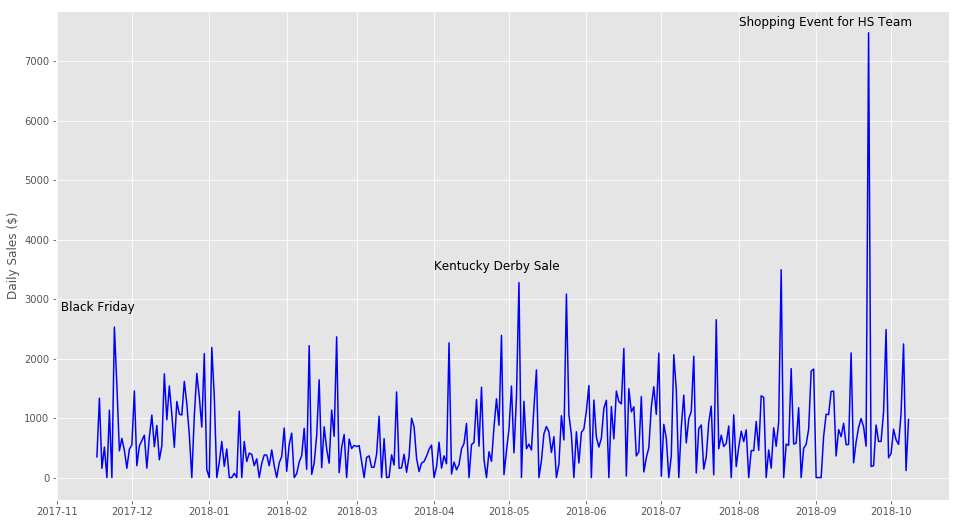

In [45]:
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(daily_sales_df['sales'], color='Blue')
plt.ylabel('Daily Sales ($)')
plt.text('2017-11', 2800, ' Black Friday', size=12)
plt.text('2018-04', 3500, 'Kentucky Derby Sale', size=12)
plt.text('2018-08', 7600, 'Shopping Event for HS Team', size=12)
plt.show()

### Weekly Trend

A deeper look at average sales by day shows the weekly trend where Saturdays have much stronger sales than other
days of the week. Makes sense since both adults and juniors have more time to shop on weekends. Note that the store
is only open on Sundays during the Holiday season.

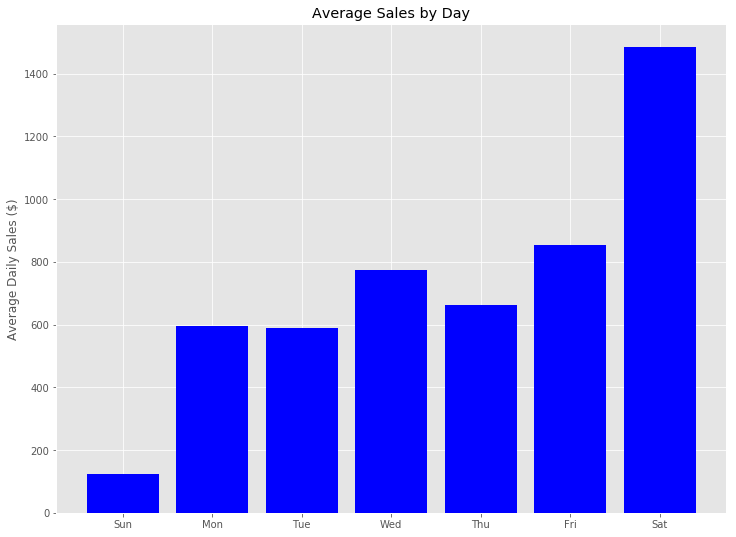

In [46]:
days = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
avg_sales_by_day = daily_sales_df[['sales']].groupby(daily_sales_df.day).mean()
avg_sales_by_day['day'] = avg_sales_by_day.index.map(pd.Series(days))

fig, ax = plt.subplots(figsize=(12,9))
plt.bar(avg_sales_by_day['day'], avg_sales_by_day['sales'], color='Blue')
plt.ylabel('Average Daily Sales ($)')
plt.title('Average Sales by Day')
plt.show()

### Monthly Trend
Average sales by month shows the seasonal trend mentioned above with slower sales during the Winter months. 

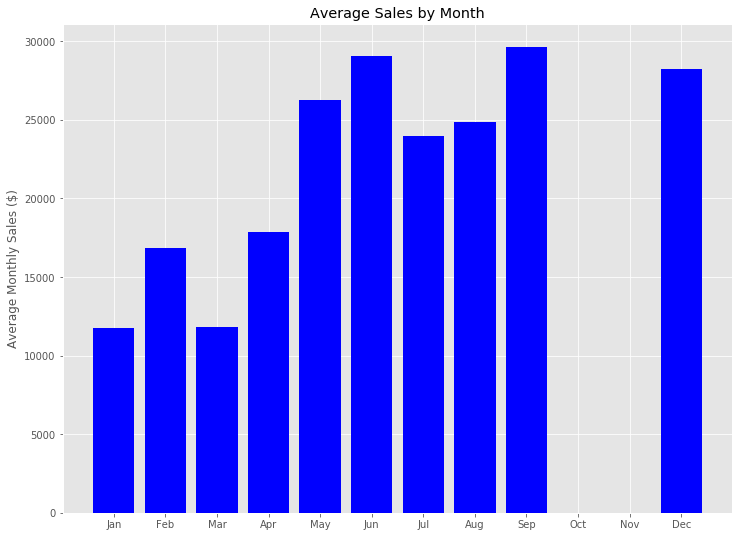

In [47]:
months = ['None', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
avg_sales_by_month = daily_sales_df[['sales']].groupby(daily_sales_df.month).sum()
avg_sales_by_month['month'] = avg_sales_by_month.index.map(pd.Series(months))

# Only have partial for Oct & Nov so ignore those for now
avg_sales_by_month.loc[10,'sales'] = 0.0
avg_sales_by_month.loc[11,'sales'] = 0.0

fig, ax = plt.subplots(figsize=(12,9))
plt.bar(avg_sales_by_month['month'], avg_sales_by_month['sales'], color='Blue')
plt.ylabel('Average Monthly Sales ($)')
plt.title('Average Sales by Month')
plt.show()

### Customer Trend
As expected, there's a definite trend in the number of customers per day with more people shopping on Friday and Saturday.

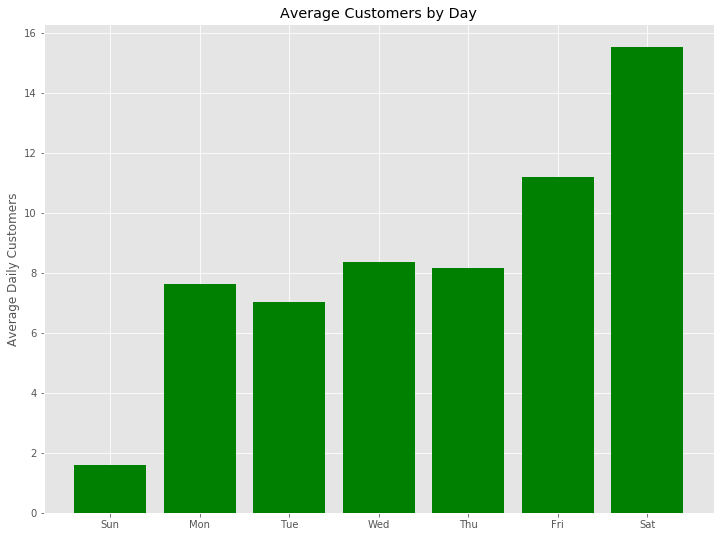

In [48]:
avg_customers_by_day = daily_sales_df[['customers']].groupby(daily_sales_df.day).mean()
avg_customers_by_day['day'] = avg_customers_by_day.index.map(pd.Series(days))

fig, ax = plt.subplots(figsize=(12,9))
plt.bar(avg_customers_by_day['day'], avg_customers_by_day['customers'], color='Green')
plt.ylabel('Average Daily Customers')
plt.title('Average Customers by Day')
plt.show()

### Average Sale Value
With the exception of winter months, average sale value remained fairly constant month to month. This is the amount customers spend on average at checkout. Customers hibernate during winter and buy only essential items either for the animals or cold-weather indoor riding. As the snow clears, spending picks up and you can see customers purchasing more expensive items, in many cases for a new season of competition. You see this again in Sept as High School & College teams get outfitted for IEA and IHSA competition that starts in October.

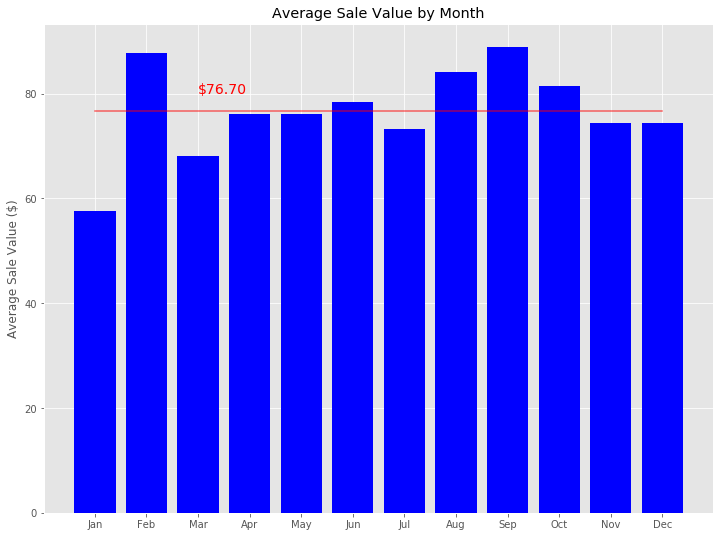

        avg_sale          mean
count  12.000000  1.200000e+01
mean   76.702759  7.670276e+01
std     8.610273  1.484275e-14
min    57.574600  7.670276e+01
25%    74.074844  7.670276e+01
50%    76.128017  7.670276e+01
75%    82.088246  7.670276e+01
max    88.912552  7.670276e+01


In [49]:
avg_sale_by_month = daily_sales_df[['avg_sale']].groupby(daily_sales_df.month).mean()
avg_sale_by_month['month'] = avg_sale_by_month.index.map(pd.Series(months))
avg_sale_by_month['mean'] = avg_sale_by_month['avg_sale'].mean()

fig, ax = plt.subplots(figsize=(12,9))
plt.bar(avg_sale_by_month['month'], avg_sale_by_month['avg_sale'], color='Blue')
plt.plot(avg_sale_by_month['month'], avg_sale_by_month['mean'], color='Red', alpha=0.6)
plt.text('Mar', 80, '$76.70', color='Red', size=14)
plt.ylabel('Average Sale Value ($)')
plt.title('Average Sale Value by Month')
plt.show()

print(avg_sale_by_month.describe())

### Forecasting Sales Spikes

It's already clear that challenge with this project is going to be pedicting the magnitude of sale and event-driven spikes. Timing is easy enough since the business knows it's going to be advertising a sale well in advance. But how many people will show and what will their spending pattern be like ?

Look at a few of the examples called out in the plot below.  Increased customer traffic certainly can explain some of the sales spikes but not all. In many instances, like the 3 pointed out below, there is also an increase in spending pattern. Some of these might be predicted. In the case of the "Helmet Awareness" sale, you could expect customers would be spending more than normal to update a relatively expensive item like a helmet. Others like the labeled spike in late May cannot be predicted yet with the available data.

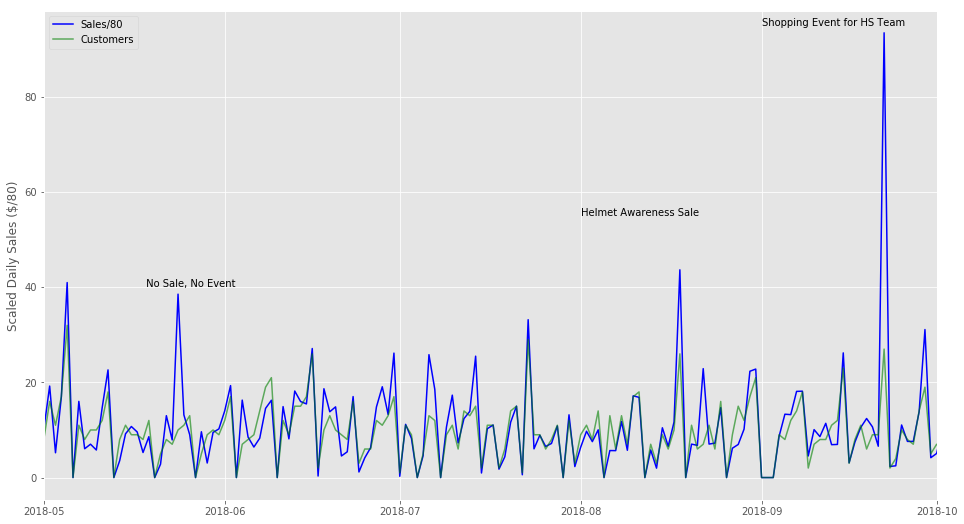

In [50]:
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(daily_sales_df['sales']/80.0, label='Sales/80', color='Blue')
plt.plot(daily_sales_df['customers'], color='Green', alpha=0.6, label='Customers')
plt.text('2018-05-18', 40, ' No Sale, No Event')
plt.text('2018-08', 55, 'Helmet Awareness Sale')
plt.text('2018-09', 95, 'Shopping Event for HS Team')
plt.ylabel('Scaled Daily Sales ($/80)')
plt.legend()
ax.set_xlim(['2018-05', '2018-10'])
plt.show()

### Customer Traffic

How many people are likely to respond to a sale event ? Since all sale events are posted on the business' Facebook page, this might be a good signal. See the plot below showing scaled FB Reach vs. Customers. On the surface, this does not seem to be a helpful feature in estimating shopper traffic. In some cases such as the first spike in May, increased FB reach falls on the same day as the increase in shoppers. In others, like the FB reach spike in early July, the reach has nothing to do with product and would be a false signal of a large shopper increase.

In [51]:
fb_reach = pd.read_excel('../data/fb-page_impressions_organic_unique.xlsx', index_col='date', parse_dates=True)
fb_reach.head()

,organic_reach
date,
2017-11-17,1031
2017-11-18,1775
2017-11-19,2172
2017-11-20,599
2017-11-21,890


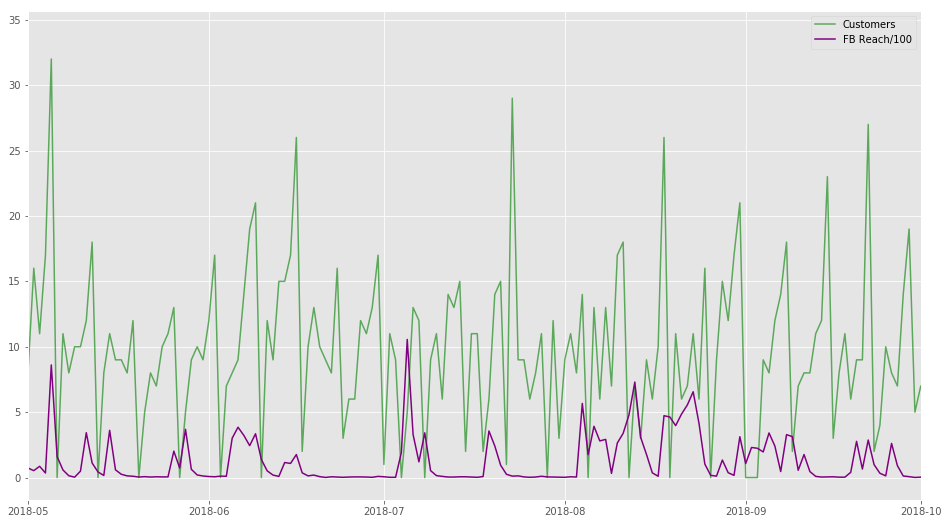

In [52]:
sales_by_week = daily_sales_df['sales'].rolling(window=14).mean()
customers_by_week = daily_sales_df['customers'].rolling(window=7).mean()

fig, ax = plt.subplots(figsize=(16,9))
plt.plot(daily_sales_df['customers'], color='Green', alpha=0.6, label='Customers')
plt.plot(fb_reach/100.0, color='Purple', label='FB Reach/100')
plt.legend()
ax.set_xlim(['2018-05', '2018-10'])
plt.show()

### Looking Ahead - Lag Scatter Plots

Forecasting sales is a time series problem. Unlike "normal" supervised machine learning, the order of observations matters in a time series. A time series problem can be adapted to supervised learning by using prior values at (t-?) to predict current values. The 'minus ?' is called a lag. In this case, we've already seen above that not all days are equal in terms of sales. Saturdays tend to have much stronger sales than Mondays. So, using a lag value of 7 (1 week) makes sense.

The scatter plots below show the current observation vs lags of 1 - 4 weeks.  As expected, there seems to be a positive relationship between the current observation and those from a week earlier - with the exception of sales spikes. Note how the relationship weakens over time. You see a tight cluster with T-1 week and a much more disbursed plot at T-4 weeks.

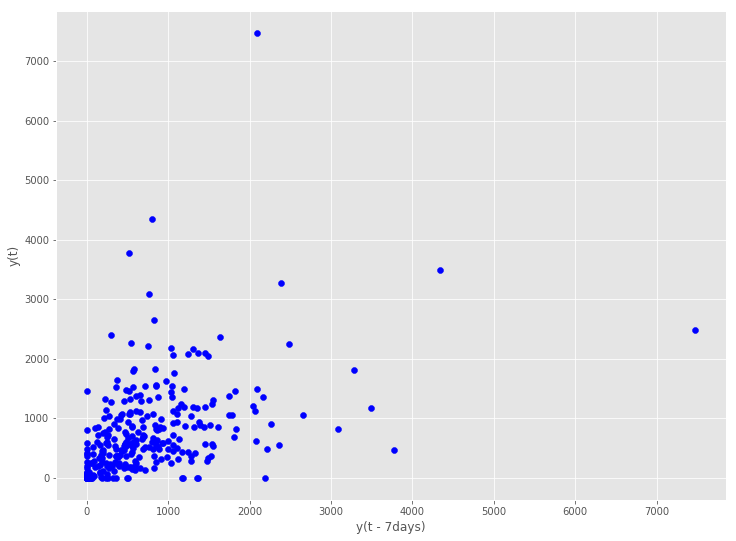

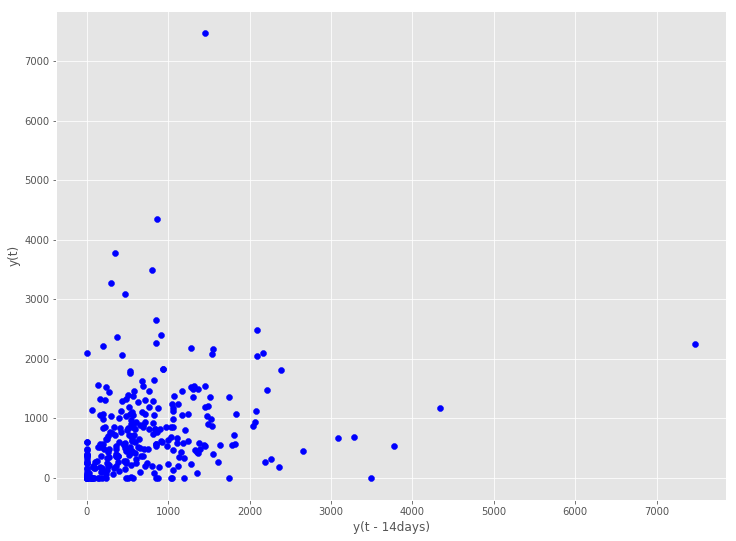

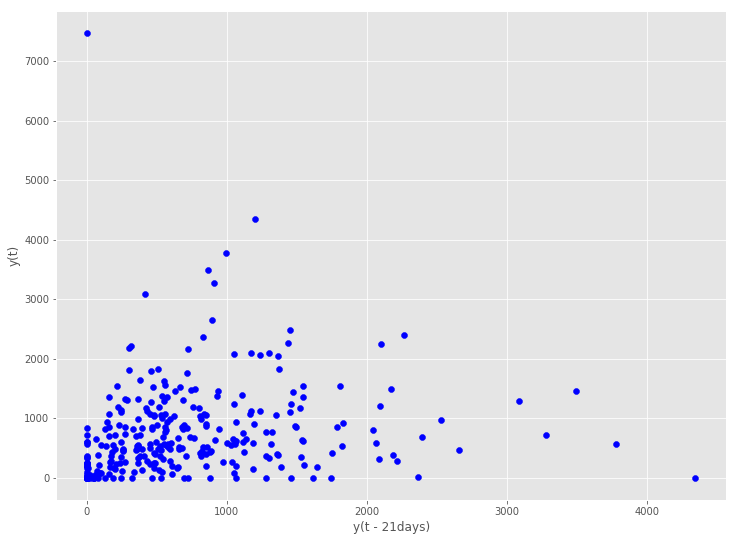

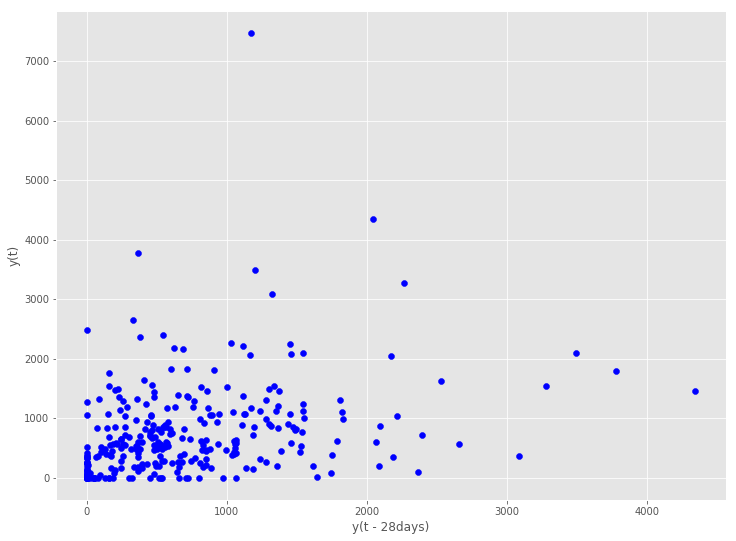

In [53]:
lag_df = pd.read_csv('../data/daily-sales-4lag.csv', index_col='date', parse_dates=True)

for n in range(4):
    fig, ax = plt.subplots(figsize=(12,9))
    lag_days = (n + 1) * 7
    lag_col = 'sales_t-{}'.format(lag_days)
    plt.scatter(lag_df[lag_col], lag_df['y'], color='Blue')
    plt.ylabel('y(t)')
    plt.xlabel('y(t - {}days)'.format(lag_days))
    plt.show()